In [8]:
import cv2
import numpy as np
import torch
from PIL import Image
from utils.transform_utils import generateTrainImagePair,get_warp_flow
from dataset import BaseDataset
import torch.optim as optim
from torch.utils.data import DataLoader
from utils.train_utils import tensor_gpu
dataset = BaseDataset(image_dir="/CV/gaobiaoli/dataset/CIS-Dataset/train",ratio=0.1,patch_size=128)
dataloader=DataLoader(dataset=dataset,batch_size=32,num_workers=4)
for i,data in enumerate(dataloader):
    break

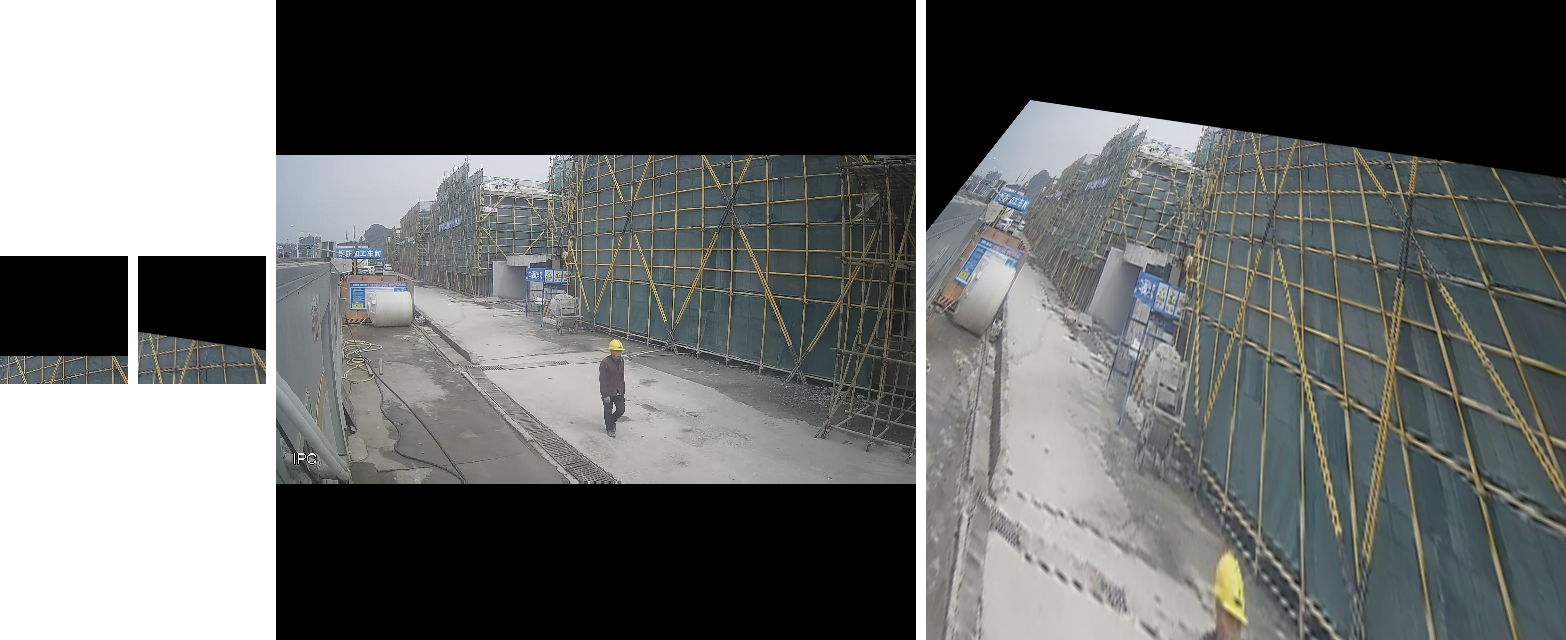

In [20]:
def show_tensor(tensor):
    if tensor.is_cuda:
        tensor = tensor.cpu()
    ndarray = tensor.permute(1, 2, 0).numpy()  # 调整维度为 (W, H, C)
    ndarray = np.clip(ndarray, 0, 255).astype(np.uint8)
    return Image.fromarray(ndarray)

def display_images_in_row(images, padding=10, bg_color=(255, 255, 255)):
    """
    将多个图像在一行中拼接显示。

    Args:
        images (list): 图像列表，每个图像为 PIL.Image.Image 实例。
        padding (int): 图像之间的间距。
        bg_color (tuple): 背景颜色 (R, G, B)。
    
    Returns:
        PIL.Image.Image: 拼接后的图像。
    """
    # 获取每个图像的宽高，并计算总宽度和最大高度
    widths, heights = zip(*(img.size for img in images))
    total_width = sum(widths) + padding * (len(images) - 1)
    max_height = max(heights)
    
    # 创建背景图像
    combined_image = Image.new("RGB", (total_width, max_height), bg_color)
    
    # 拼接图像
    x_offset = 0
    for img in images:
        combined_image.paste(img, (x_offset, (max_height - img.height) // 2))
        x_offset += img.width + padding

    return combined_image
id=0
display_images_in_row([show_tensor(data['img1_patch'][id]*255),show_tensor(data['img2_patch'][id]*255),show_tensor(data['img1_full'][id]*255),show_tensor(data['img2_full'][id]*255)])

In [ ]:
tensor_gpu(data)
img1_from_full=get_warp_flow(data['img2_full'],data['flow_img2'].permute(0,3,1,2),start=data['origin_corners'][:,0,:])
img1_from_patch=get_warp_flow(data['img2_patch'],data['flow_img2'].permute(0,3,1,2))
display_images_in_row([show_tensor(img1_from_full[0]*255),show_tensor(img1_from_patch[0]*255)])

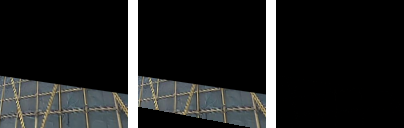

In [26]:
img2_from_full=get_warp_flow(data['img1_full'],data['flow_img1'].permute(0,3,1,2),start=data['origin_corners'][:,0,:])
img2_from_patch=get_warp_flow(data['img1_patch'],data['flow_img1'].permute(0,3,1,2))
display_images_in_row([show_tensor(img2_from_full[0]*255),show_tensor(img2_from_patch[0]*255),show_tensor(img2_from_full[0]*255-data['img2_patch'][id]*255)])

In [7]:
img

tensor([[[[ 83,  68,  55,  ..., 150, 135,  30],
          [ 98,  99,  96,  ..., 116, 163, 102],
          [101, 101, 100,  ...,  58, 141, 160],
          ...,
          [115, 115, 116,  ..., 165, 163, 158],
          [117, 116, 116,  ..., 157, 153, 146],
          [121, 120, 121,  ..., 160, 154, 146]],

         [[ 47,  29,  16,  ..., 163, 148,  45],
          [ 62,  63,  57,  ..., 129, 176, 117],
          [ 67,  67,  64,  ...,  73, 156, 173],
          ...,
          [138, 138, 136,  ..., 145, 144, 140],
          [137, 136, 135,  ..., 137, 134, 128],
          [140, 139, 138,  ..., 140, 135, 128]],

         [[ 47,  30,  17,  ..., 169, 154,  50],
          [ 62,  63,  58,  ..., 135, 182, 122],
          [ 66,  66,  64,  ...,  78, 161, 179],
          ...,
          [144, 144, 143,  ..., 134, 130, 126],
          [144, 143, 142,  ..., 126, 120, 114],
          [147, 146, 146,  ..., 129, 121, 114]]]], device='cuda:0',
       dtype=torch.uint8)

In [ ]:
import torch.nn as nn
def warp(x, flo):
    """
    warp an image/tensor (im2) back to im1, according to the optical flow
    x: [B, C, H, W] (im2)
    flo: [B, 2, H, W] flow
    """
    B, C, H, W = x.size()
    # mesh grid
    xx = torch.arange(0, W).view(1, -1).repeat(H, 1)
    yy = torch.arange(0, H).view(-1, 1).repeat(1, W)
    xx = xx.view(1, 1, H, W).repeat(B, 1, 1, 1)
    yy = yy.view(1, 1, H, W).repeat(B, 1, 1, 1)
    grid = torch.cat((xx, yy), 1).float()

    if x.is_cuda:
        grid = grid.to(x.device)
    vgrid = torch.autograd.Variable(grid) + flo

    # scale grid to [-1,1]
    vgrid[:, 0, :, :] = 2.0 * vgrid[:, 0, :, :] / max(W - 1, 1) - 1.0
    vgrid[:, 1, :, :] = 2.0 * vgrid[:, 1, :, :] / max(H - 1, 1) - 1.0

    vgrid = vgrid.permute(0, 2, 3, 1)
    output = nn.functional.grid_sample(x, vgrid, align_corners=True)
    mask = torch.autograd.Variable(torch.ones(x.size())).to(x.device)
    mask = nn.functional.grid_sample(mask, vgrid, align_corners=True)

    mask[mask < 0.999] = 0
    mask[mask > 0] = 1

    return output * mask
img3=warp(image.float(),flow.float()).squeeze().permute(1,2,0).cpu().numpy().astype(np.uint8)

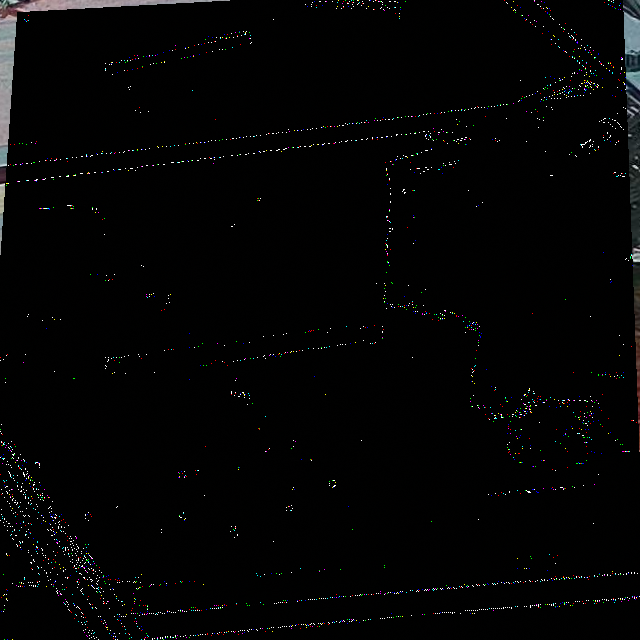

: 

In [ ]:
Image.fromarray(img_warp-img3)